#### We would use LDA reduction technique along with oversampling SMOTE to check for scores difference in f1-macro/micro

In [1]:
import pandas as panda
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,label_binarize

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,\
    RepeatedStratifiedKFold,learning_curve

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, \
        classification_report,confusion_matrix,average_precision_score
from sklearn.linear_model import Perceptron, LogisticRegression,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plot
from itertools import cycle
import numpy as np 
from scipy import interp
import seaborn as sns
import itertools, time, datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from numpy import bincount, linspace, mean, std, arange, squeeze

import warnings

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
np.random.seed(123)

In [3]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

In [5]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))





def calculate_roc_and_prec_metrics(y, y_probabilities, number_of_classes):
    
    false_positive_rate_across_class    = dict()
    true_positive_rate_across_class     = dict()
    recall_across_class                 = dict()
    precision_across_class              = dict()
    roc_auc_across_class                = dict()
    average_precision_across_class      = dict()


    for i in range(number_of_classes):

        false_positive_rate_across_class[i], \
                true_positive_rate_across_class[i], _ = roc_curve(y[:, i], y_probabilities[:, i])

        precision_across_class[i], recall_across_class[i], _ = precision_recall_curve(y[:, i],
                                                        y_probabilities[:, i])

        average_precision_across_class[i] = average_precision_score(y[:, i], y_probabilities[:, i])

        roc_auc_across_class[i] = auc(false_positive_rate_across_class[i], true_positive_rate_across_class[i])

        # Compute micro-average ROC curve and ROC area

        false_positive_rate_across_class["micro"], \
                true_positive_rate_across_class["micro"], _ = roc_curve(y.ravel(), y_probabilities.ravel())

        roc_auc_across_class["micro"] = auc(false_positive_rate_across_class["micro"], \
                            true_positive_rate_across_class["micro"])


        precision_across_class["micro"], recall_across_class["micro"], _ = \
                    precision_recall_curve(y.ravel(), y_probabilities.ravel())

        average_precision_across_class["micro"] = average_precision_score(y, y_probabilities,
                                                            average="micro")

    response  = dict() 
    response['false_positive_rate_across_class']    = false_positive_rate_across_class
    response['true_positive_rate_across_class']     = true_positive_rate_across_class
    response['recall_across_class']                 = recall_across_class
    response['precision_across_class']              = precision_across_class
    response['roc_auc_across_class']                = roc_auc_across_class
    response['average_precision_across_class']      = average_precision_across_class

    return response


def plot_roc_auc_curve(false_positive_rate_across_class, \
            true_positive_rate_across_class, roc_auc_across_class, n_classes):
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([false_positive_rate_across_class[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += interp(all_fpr, false_positive_rate_across_class[i], true_positive_rate_across_class[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    false_positive_rate_across_class["macro"] = all_fpr
    true_positive_rate_across_class["macro"] = mean_tpr
    roc_auc_across_class["macro"] = auc(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"])

    # Plot all ROC curves
    plot.figure(figsize = (15,5))
    plot.plot(false_positive_rate_across_class["micro"], true_positive_rate_across_class["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plot.plot(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plot.plot(false_positive_rate_across_class[i], true_positive_rate_across_class[i], color=color, lw=4,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc_across_class[i]))

    plot.plot([0, 1], [0, 1], 'k--', lw=4)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.title('Some extension of Receiver operating characteristic to multi-class')
    plot.legend(loc="lower right")
    plot.show()




def plot_precision_recall_curve(recall_across_class, \
            precision_across_class, average_precision_across_class, n_classes):

    line_width = 4
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plot.figure(figsize=(15, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plot.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plot.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plot.plot(recall_across_class["micro"], precision_across_class["micro"], color='gold', lw=line_width)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision_across_class["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plot.plot(recall_across_class[i], precision_across_class[i], color=color, lw=line_width)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(i, average_precision_across_class[i]))

    fig = plot.gcf()
    fig.subplots_adjust(bottom=0.25)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('Recall')
    plot.ylabel('Precision')
    plot.title('Extension of Precision-Recall curve to multi-class')
#     plot.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))
    plot.legend(lines, labels, loc='best', prop=dict(size=14))
    plot.show()

    

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
    
    
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)

    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
#         _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(range(_y_test.shape[1])))
        _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(set(_y_test)))
        classes = list(set(_y_test))
        plot_confusion_matrix(_matrix, classes)
        
    with predict_proba_timer:

        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            print('inside decision function')
            y_probability = gridsearch.predict_proba(x_test)
            number_of_classes = len(np.unique(y_train))
            y_test_bin = label_binarize(y_test, classes = np.unique(y_train))
            response = calculate_roc_and_prec_metrics(y_test_bin, y_probability, number_of_classes = number_of_classes)

            roc_params = {

                'false_positive_rate_across_class': response.get('false_positive_rate_across_class'),
                'true_positive_rate_across_class': response.get('true_positive_rate_across_class'),
                'roc_auc_across_class': response.get('roc_auc_across_class'),
                'n_classes': number_of_classes
            }

            precision_recall_params  = {

                'precision_across_class': response.get('precision_across_class'),
                'average_precision_across_class': response.get('average_precision_across_class'),
                'recall_across_class': response.get('recall_across_class'),
                'n_classes': number_of_classes
            }

            plot_roc_auc_curve(**roc_params)
            plot_precision_recall_curve(**precision_recall_params)
            response['roc_auc_micro'] = response.get('roc_auc_across_class',{}).get("micro")
            response['roc_auc_macro'] = response.get('roc_auc_across_class',{}).get("macro")
            
            
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_micro'] = 0
            response['roc_auc_macro'] = 0
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['f1_score_micro']  = f1_score(y_test, y_prediction, average ='micro')
    response['f1_score_macro']  = f1_score(y_test, y_prediction, average ='macro')
    response['best_estimator'] = search.best_estimator_
    response['confusion_matrix'] = _matrix
    
    return response


In [6]:

## we will add more classifiers in round2
classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state = 1),
    KNeighborsClassifier(metric = 'minkowski'),
    RidgeClassifier(random_state = 123), 
    SVC(kernel='rbf',class_weight='balanced',probability=True)
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'ridge',
            'svc'
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
            {'logisticregression__C':[100,300, 500]},
            {'decisiontreeclassifier__max_depth':[6,8,10],'decisiontreeclassifier__criterion':['gini','entropy']},
            {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini',]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,10]},
            {'ridge__alpha':[1,1.2,0.9],'ridge__max_iter':[100,300,500]},
            {'svc__C':[1,1.2,0.5], 'svc__max_iter':[100,200]}
    
]


In [7]:

def execute( _x_train,
             _y_train,
             _x_test,
             _y_test, 
            classifiers, 
            classifier_names, 
            classifier_param_grid,
            cv  = 10 , 
            score = 'accuracy',
            scaler = StandardScaler()
           ):
    
    '''
    This method will run your data sets against the model specified 
    Models will be fed through a pipeline where the first step would be to
    execute a scaling operation.
    
    Method will also call additional lower level methods in order to plot
    precision curve, roc curve, learning curve and will also prepare a confusion matrix
    
    :returns: dict containing execution metrics such as time taken, accuracy scores
    :returntype: dict
    
    '''

    timer = CodeTimer(name='overalltime')
    model_metrics = {}

    with timer:
        for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

            pipeline = Pipeline([
#                     ('scaler', scaler),since we have already done dimensionality reduction, we dont need to rescale
                    (model_name, model)
            ])

            result = runGridSearchAndPredict(pipeline, 
                                             _x_train,
                                             _y_train,
                                             _x_test,
                                             _y_test, 
                                             model_param_grid ,
                                             cv = cv,
                                             score = 'f1_weighted')

            _y_prediction = result['_y_prediction']

#             cf = panda.crosstab(
#                 panda.Series(_y_test, name='Actual'),
#                 panda.Series(_y_prediction, name = 'Prediction'),
#                 margins = True
#             )

#             print(cf)

            model_metrics[model_name] = {}
            model_metrics[model_name]['confusion_matrix'] = result.get('confusion_matrix')
            model_metrics[model_name]['training_time'] = result.get('training_time')
            model_metrics[model_name]['testing_time'] = result.get('testing_time')
            model_metrics[model_name]['learning_curve_time'] = result.get('learning_curve_time')
            model_metrics[model_name]['f1_score'] = result.get('f1_score')
            model_metrics[model_name]['f1_score_macro'] = result.get('f1_score_macro')
            model_metrics[model_name]['f1_score_micro'] = result.get('f1_score_micro')
            model_metrics[model_name]['roc_auc_macro'] = result.get('roc_auc_macro')
            model_metrics[model_name]['roc_auc_micro'] = result.get('roc_auc_micro')

            model_metrics[model_name]['best_estimator'] = result.get('best_estimator')
#             model_metrics[model_name]['cf'] = cf


    print(timer.took)
    
    return model_metrics


In [8]:
train_data = panda.read_csv('data/train_2.csv')
test_data = panda.read_csv('data/test_2.csv')

In [9]:

columns_not_required = ['id','idhogar','target']
x = train_data[[i for i in train_data.columns.tolist() if i not in columns_not_required]]
y = train_data['target']


In [10]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)




In [11]:
## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
_x_train, _y_train = smt.fit_sample(_x_train, _y_train)

# smote = SMOTE(ratio='minority')
# x_train, y_train = smote.fit_sample(_x_train,_y_train)

# tl = TomekLinks(return_indices=True, ratio='majority')
# _x_train, _y_train, id_tl = tl.fit_sample(_x_train, _y_train)



In [12]:
scaler = StandardScaler()
x_train_std = scaler.fit_transform(_x_train)
x_test_std = scaler.fit_transform(_x_test)

In [13]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_std, _y_train)
x_train_lda = lda.transform(x_train_std)
x_test_lda = lda.transform(x_test_std)


In [14]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 30}
Grid Search Best score  0.4895985127067202
Code block 'training' took(HH:MM:SS): 0:00:00.245627
Code block 'testing' took(HH:MM:SS): 0:00:00.000364
F1 score 0.4598850116969867
Classification report  
               precision    recall  f1-score   support

           1       0.16      0.39      0.23        67
           2       0.19      0.64      0.30       133
           3       0.00      0.00      0.00       106
           4       0.91      0.45      0.61       586

   micro avg       0.42      0.42      0.42       892
   macro avg       0.32      0.37      0.28       892
weighted avg       0.64      0.42      0.46       892



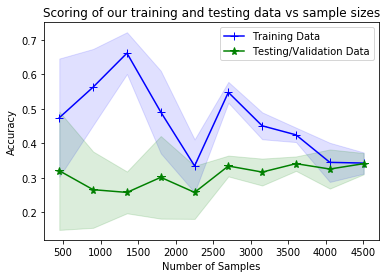

Confusion matrix, without normalization
[[ 26  36   0   5]
 [ 36  85   0  12]
 [ 17  81   0   8]
 [ 83 237   0 266]]


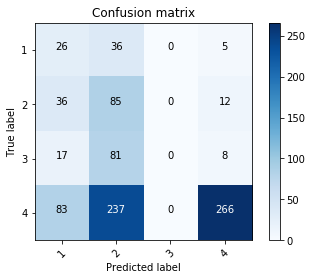

Code block 'learning_curve' took(HH:MM:SS): 0:00:12.319478
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000016
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.6450564442585629
Code block 'training' took(HH:MM:SS): 0:00:00.209330
Code block 'testing' took(HH:MM:SS): 0:00:00.000457
F1 score 0.4927424066705139
Classification report  
               precision    recall  f1-score   support

           1       0.16      0.46      0.24        67
           2       0.22      0.33      0.26       133
           3       0.19      0.36      0.25       106
           4       0.92      0.47      0.62       586

   micro avg       0.43      0.43      0.43       892
   macro avg       0.37      0.40      0.34       892
weighted avg       0.67      0.43      0.49       892



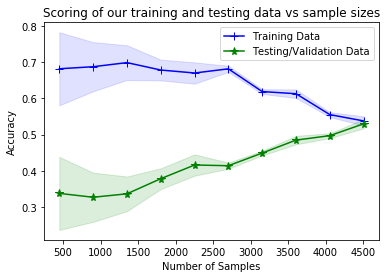

Confusion matrix, without normalization
[[ 31  22  10   4]
 [ 42  44  33  14]
 [ 29  33  38   6]
 [ 89 104 120 273]]


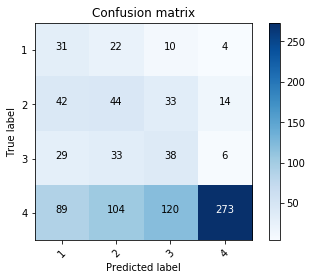

Code block 'learning_curve' took(HH:MM:SS): 0:00:34.662113
inside decision function


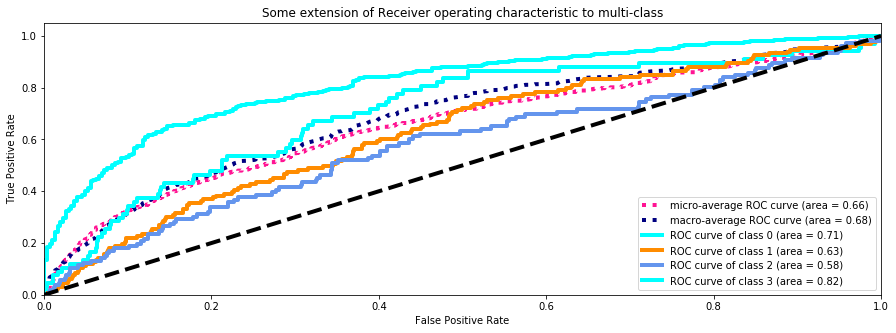

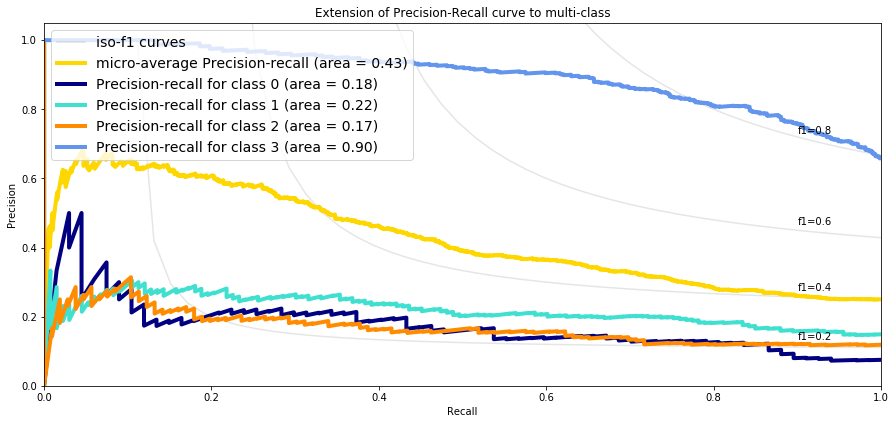

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.462244
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6}
Grid Search Best score  0.6551185211543378
Code block 'training' took(HH:MM:SS): 0:00:00.518910
Code block 'testing' took(HH:MM:SS): 0:00:00.000440
F1 score 0.44675890762789994
Classification report  
               precision    recall  f1-score   support

           1       0.21      0.51      0.30        67
           2       0.24      0.36      0.29       133
           3       0.14      0.38      0.20       106
           4       0.93      0.38      0.54       586

   micro avg       0.39      0.39      0.39       892
   macro avg       0.38      0.41      0.33       892
weighted avg       0.68      0.39      0.45       892



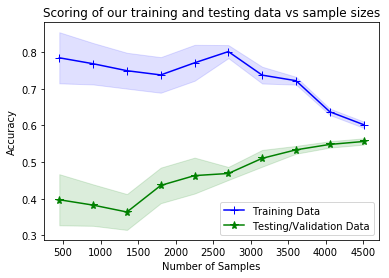

Confusion matrix, without normalization
[[ 34  16  14   3]
 [ 36  48  40   9]
 [ 24  38  40   4]
 [ 68  99 194 225]]


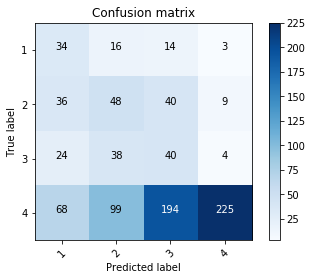

Code block 'learning_curve' took(HH:MM:SS): 0:00:06.460938
inside decision function


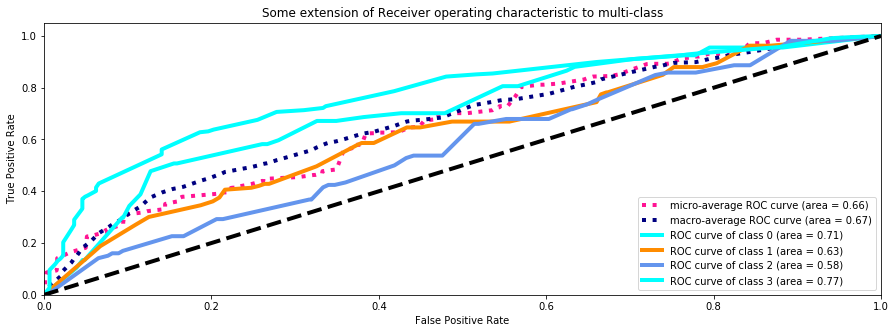

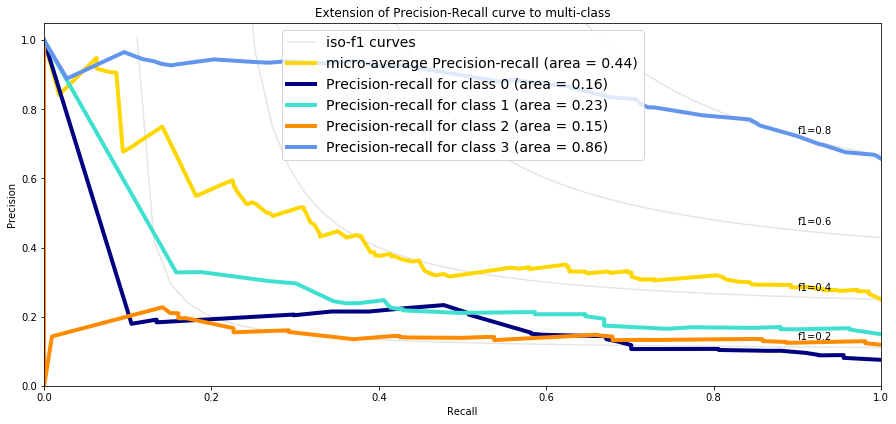

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.390030
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.6827477442613858
Code block 'training' took(HH:MM:SS): 0:00:00.684337
Code block 'testing' took(HH:MM:SS): 0:00:00.003910
F1 score 0.4539556522420158
Classification report  
               precision    recall  f1-score   support

           1       0.17      0.49      0.25        67
           2       0.19      0.30      0.23       133
           3       0.14      0.30      0.19       106
           4       0.92      0.42      0.57       586

   micro avg       0.39      0.39      0.39       892
   macro avg       0.36      0.38      0.31       892
weighted avg       0.67      0.39      0.45       892



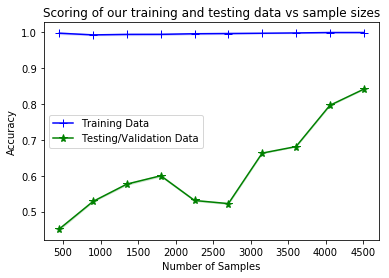

Confusion matrix, without normalization
[[ 33  19  14   1]
 [ 41  40  40  12]
 [ 29  38  32   7]
 [ 90 114 138 244]]


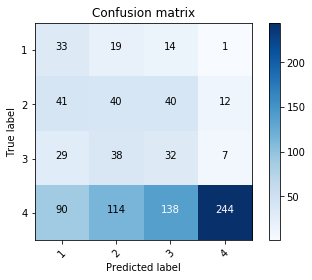

Code block 'learning_curve' took(HH:MM:SS): 0:00:09.713443
inside decision function


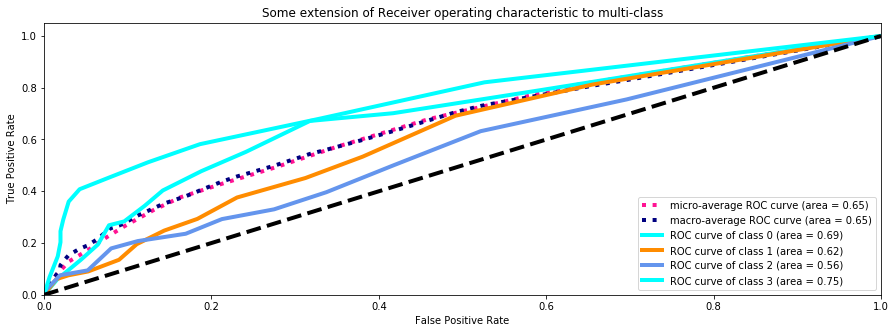

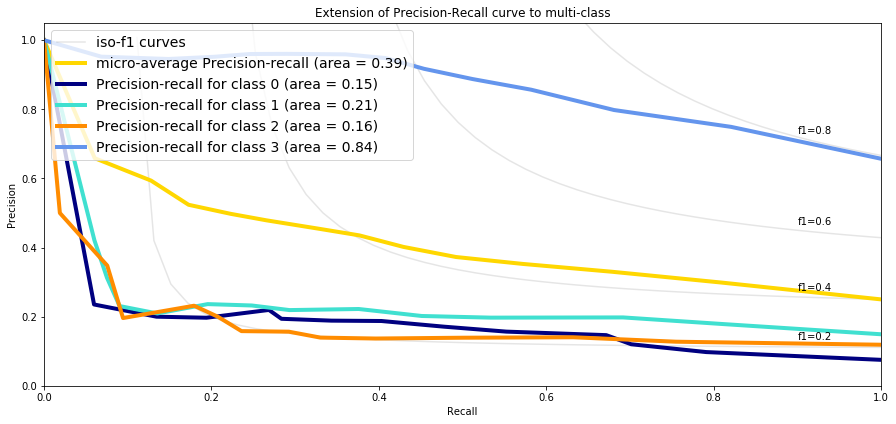

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.425173
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.6711656762218912
Code block 'training' took(HH:MM:SS): 0:00:00.409168
Code block 'testing' took(HH:MM:SS): 0:00:00.005832
F1 score 0.439639465911793
Classification report  
               precision    recall  f1-score   support

           1       0.18      0.55      0.28        67
           2       0.18      0.31      0.23       133
           3       0.17      0.38      0.24       106
           4       0.94      0.38      0.54       586

   micro avg       0.38      0.38      0.38       892
   macro avg       0.37      0.40      0.32       892
weighted avg       0.68      0.38      0.44       892



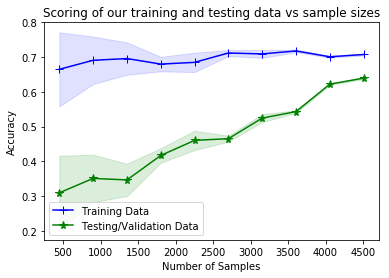

Confusion matrix, without normalization
[[ 37  21   7   2]
 [ 44  41  39   9]
 [ 27  37  40   2]
 [ 92 125 146 223]]


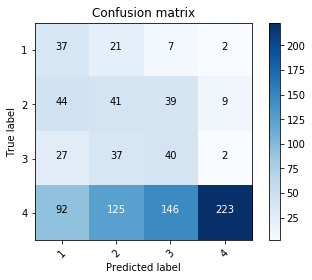

Code block 'learning_curve' took(HH:MM:SS): 0:00:34.628058
inside decision function


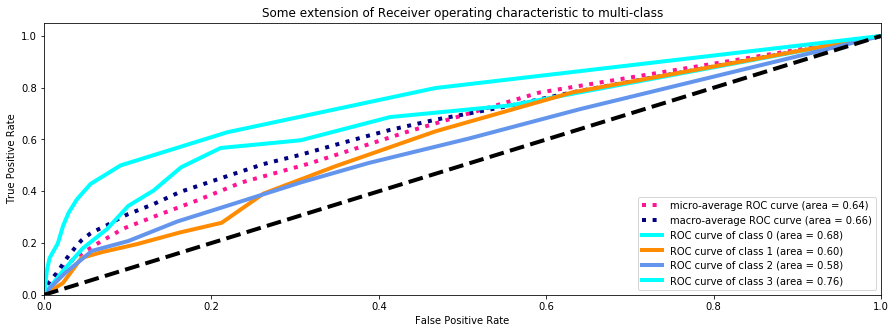

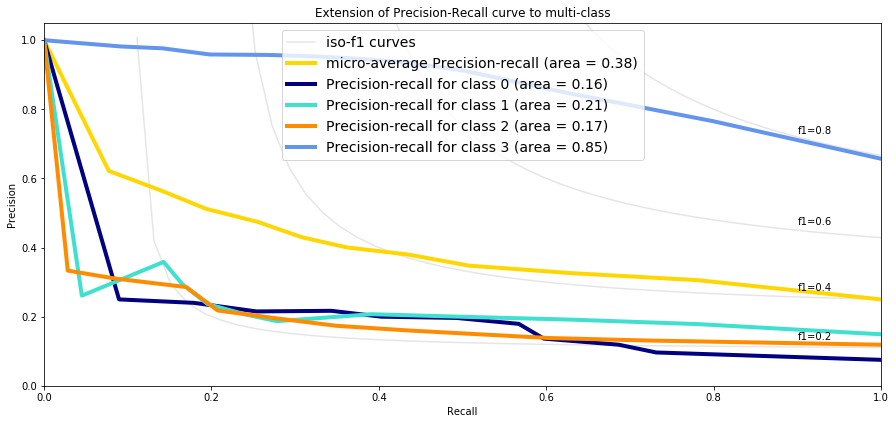

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.403451
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.6442128973865727
Code block 'training' took(HH:MM:SS): 0:00:00.212714
Code block 'testing' took(HH:MM:SS): 0:00:00.000256
F1 score 0.4935813775832957
Classification report  
               precision    recall  f1-score   support

           1       0.17      0.49      0.25        67
           2       0.22      0.32      0.26       133
           3       0.18      0.35      0.24       106
           4       0.91      0.47      0.62       586

   micro avg       0.43      0.43      0.43       892
   macro avg       0.37      0.41      0.34       892
weighted avg       0.67      0.43      0.49       892



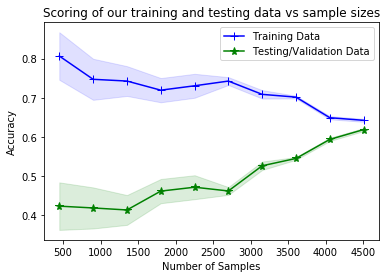

Confusion matrix, without normalization
[[ 33  20  10   4]
 [ 41  43  34  15]
 [ 30  31  37   8]
 [ 89 102 120 275]]


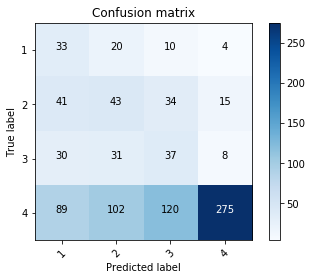

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.607329
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000015
Grid Search Best parameters  {'svc__C': 1, 'svc__max_iter': 100}
Grid Search Best score  0.20947576395675122
Code block 'training' took(HH:MM:SS): 0:00:13.754046
Code block 'testing' took(HH:MM:SS): 0:00:00.013372
F1 score 0.48049352378283156
Classification report  
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00       133
           3       0.16      0.70      0.26       106
           4       0.80      0.60      0.68       586

   micro avg       0.48      0.48      0.48       892
   macro avg       0.24      0.32      0.24       892
weighted avg       0.54      0.48      0.48       892



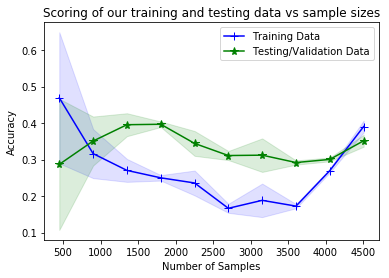

Confusion matrix, without normalization
[[  0   0  47  20]
 [  0   0  97  36]
 [  0   0  74  32]
 [  0   0 236 350]]


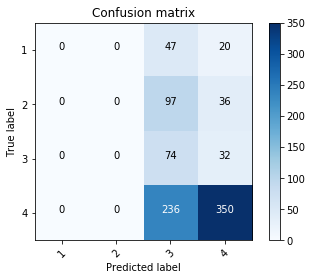

Code block 'learning_curve' took(HH:MM:SS): 0:05:02.944736
inside decision function


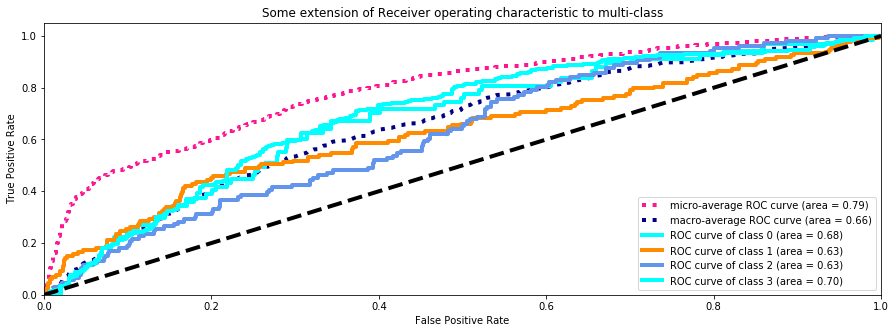

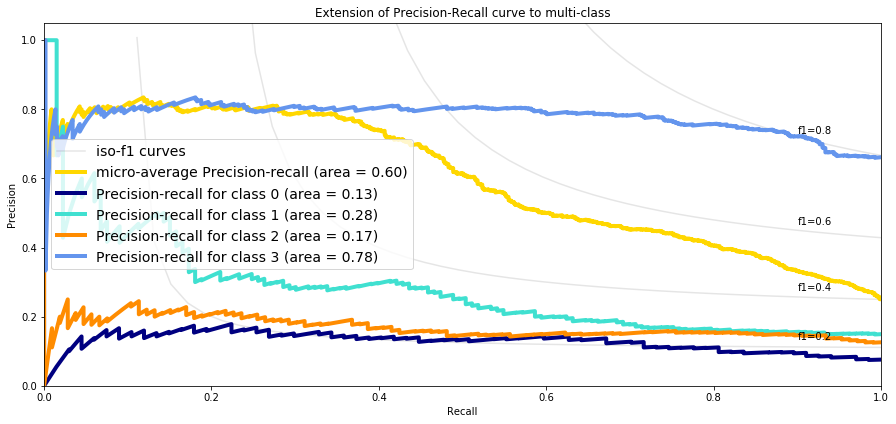

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.410470
Code block 'overalltime' took(HH:MM:SS): 0:07:00.542402
420542.40240571665


In [15]:
response = execute(x_train_lda,
        _y_train,
        x_test_lda,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [16]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
svc,0.480494,0.23697,0.475336,302945,0.65861,0.791007,13.3717,13754
ridge,0.493581,0.343914,0.434978,1607.33,0,0,0.256,212.714
logisticregression,0.492742,0.34203,0.432735,34662.1,0.684907,0.6596,0.457387,209.33
perceptron,0.459885,0.282723,0.422646,12319.5,0,0,0.364089,245.627
randomforestclassifier,0.453956,0.313615,0.391256,9713.44,0.654467,0.654889,3.90997,684.337
decisiontreeclassifier,0.446759,0.332887,0.389013,6460.94,0.672024,0.660695,0.439751,518.91
kneighborsclassifier,0.439639,0.321528,0.382287,34628.1,0.656404,0.642688,5.83225,409.168


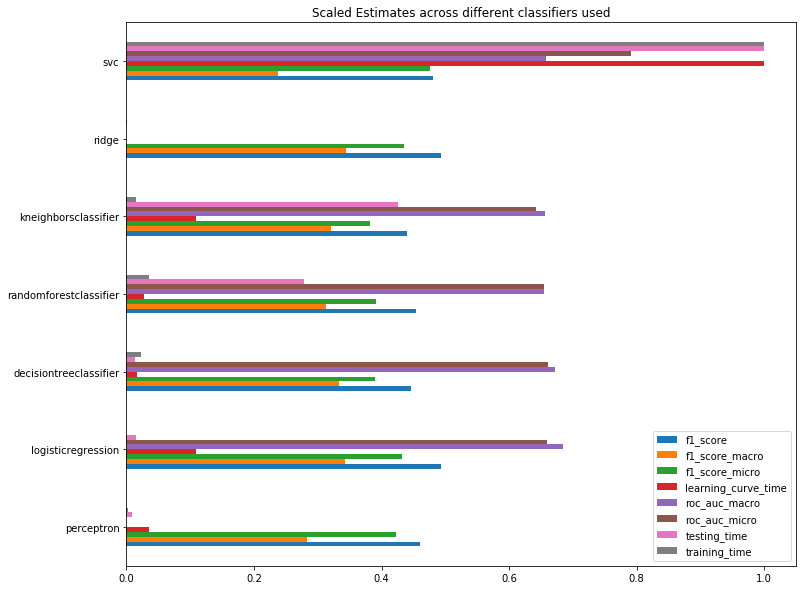

In [17]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion: Our scores reduced with auto sampling

Lets oversample the minorities now


In [18]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)




In [19]:
## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

# smt = SMOTETomek(ratio='auto')
# _x_train, _y_train = smt.fit_sample(_x_train, _y_train)

smote = SMOTE(ratio='minority')
x_train, y_train = smote.fit_sample(_x_train,_y_train)

# tl = TomekLinks(return_indices=True, ratio='majority')
# _x_train, _y_train, id_tl = tl.fit_sample(_x_train, _y_train)



In [20]:
scaler = StandardScaler()
x_train_std = scaler.fit_transform(_x_train)
x_test_std = scaler.fit_transform(_x_test)

In [21]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_std, _y_train)
x_train_lda = lda.transform(x_train_std)
x_test_lda = lda.transform(x_test_std)


In [22]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 5}
Grid Search Best score  0.6274278907450741
Code block 'training' took(HH:MM:SS): 0:00:00.126561
Code block 'testing' took(HH:MM:SS): 0:00:00.000148
F1 score 0.5852015402031782
Classification report  
               precision    recall  f1-score   support

           1       0.33      0.01      0.03        67
           2       0.24      0.39      0.30       133
           3       0.22      0.36      0.27       106
           4       0.83      0.72      0.77       586

   micro avg       0.57      0.57      0.57       892
   macro avg       0.41      0.37      0.34       892
weighted avg       0.64      0.57      0.59       892



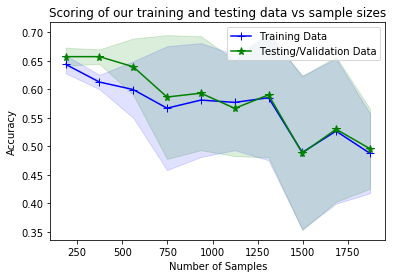

Confusion matrix, without normalization
[[  1  24  26  16]
 [  1  52  48  32]
 [  1  32  38  35]
 [  0 106  61 419]]


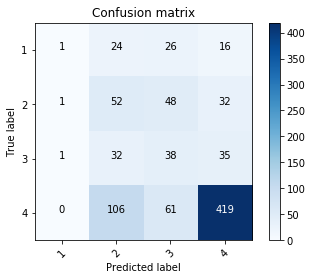

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.928508
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000016
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.6900304234033875
Code block 'training' took(HH:MM:SS): 0:00:00.094955
Code block 'testing' took(HH:MM:SS): 0:00:00.000865
F1 score 0.6067906989979795
Classification report  
               precision    recall  f1-score   support

           1       0.29      0.13      0.18        67
           2       0.34      0.27      0.30       133
           3       0.22      0.09      0.13       106
           4       0.74      0.90      0.81       586

   micro avg       0.65      0.65      0.65       892
   macro avg       0.40      0.35      0.36       892
weighted avg       0.58      0.65      0.61       892



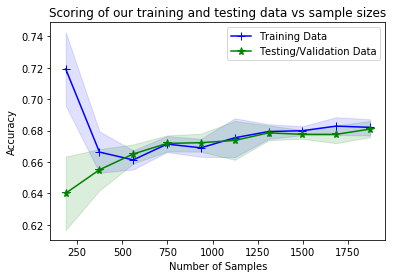

Confusion matrix, without normalization
[[  9  22   2  34]
 [  8  36  11  78]
 [  6  17  10  73]
 [  8  30  23 525]]


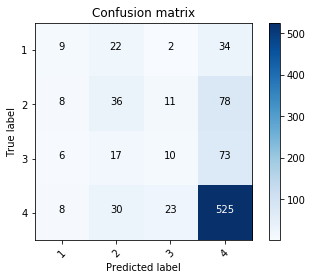

Code block 'learning_curve' took(HH:MM:SS): 0:00:11.696583
inside decision function


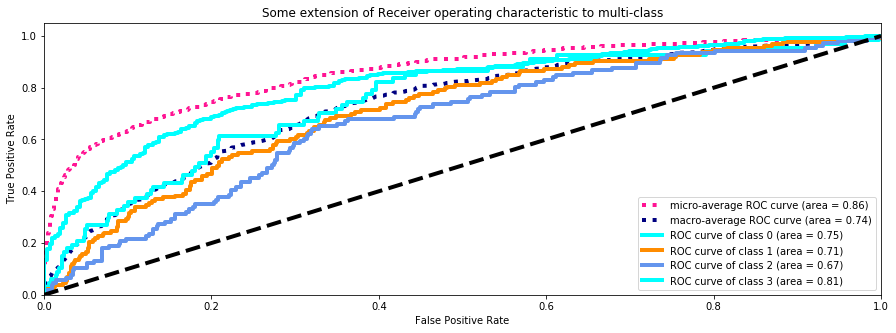

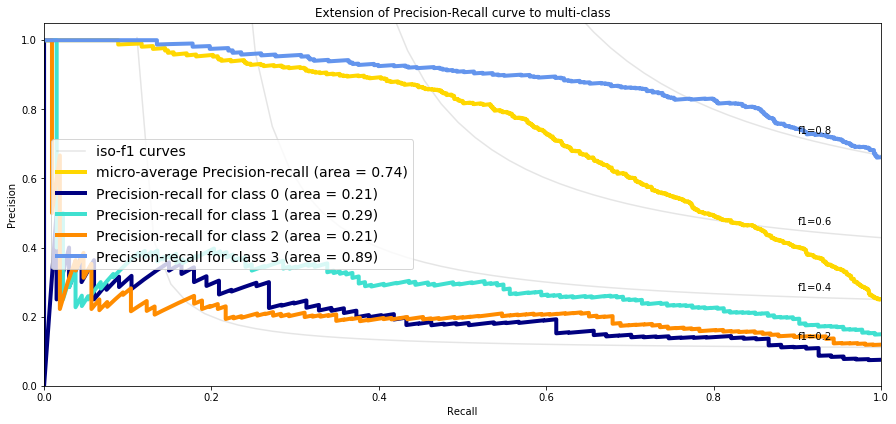

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.486867
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 10}
Grid Search Best score  0.6541070803909095
Code block 'training' took(HH:MM:SS): 0:00:00.264163
Code block 'testing' took(HH:MM:SS): 0:00:00.000222
F1 score 0.5848169671492242
Classification report  
               precision    recall  f1-score   support

           1       0.23      0.21      0.22        67
           2       0.26      0.26      0.26       133
           3       0.16      0.13      0.15       106
           4       0.76      0.80      0.78       586

   micro avg       0.59      0.59      0.59       892
   macro avg       0.35      0.35      0.35       892
weighted avg       0.58      0.59      0.58       892



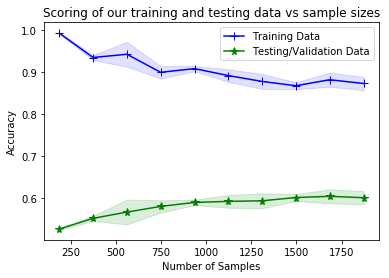

Confusion matrix, without normalization
[[ 14  20   5  28]
 [ 15  34  23  61]
 [ 11  25  14  56]
 [ 21  54  43 468]]


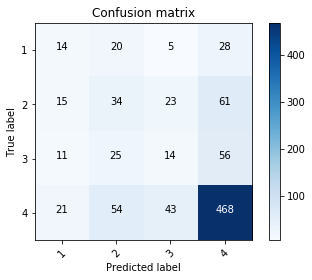

Code block 'learning_curve' took(HH:MM:SS): 0:00:03.704973
inside decision function


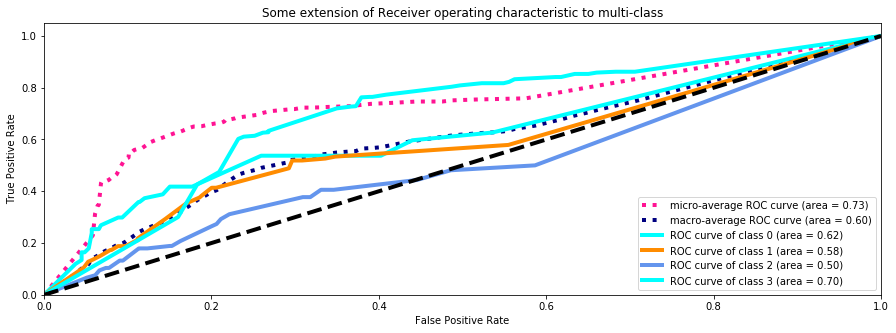

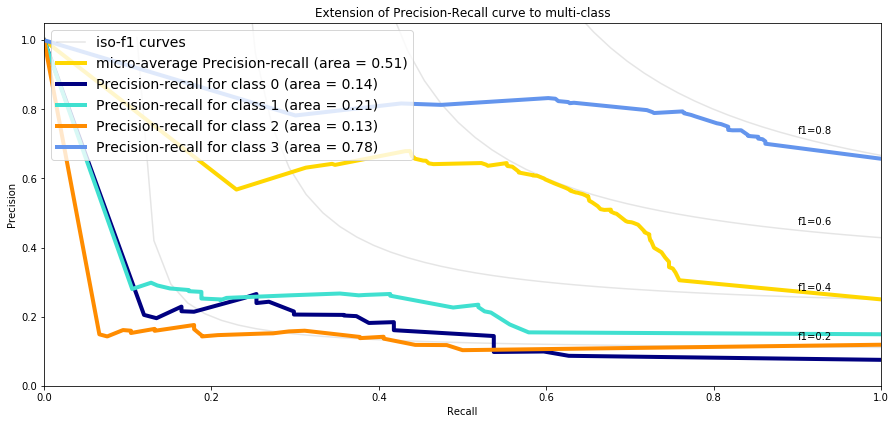

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.414895
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.6648652263003161
Code block 'training' took(HH:MM:SS): 0:00:00.366398
Code block 'testing' took(HH:MM:SS): 0:00:00.003714
F1 score 0.6225994139928218
Classification report  
               precision    recall  f1-score   support

           1       0.24      0.18      0.21        67
           2       0.31      0.29      0.30       133
           3       0.25      0.16      0.19       106
           4       0.78      0.86      0.82       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.39      0.37      0.38       892
weighted avg       0.61      0.64      0.62       892



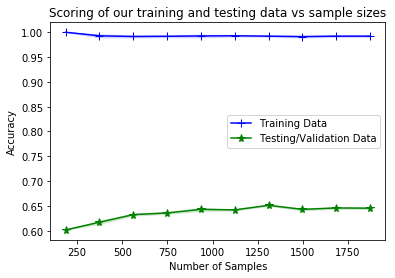

Confusion matrix, without normalization
[[ 12  23   7  25]
 [ 14  39  19  61]
 [  7  27  17  55]
 [ 17  37  26 506]]


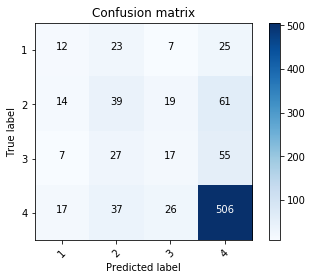

Code block 'learning_curve' took(HH:MM:SS): 0:00:04.003238
inside decision function


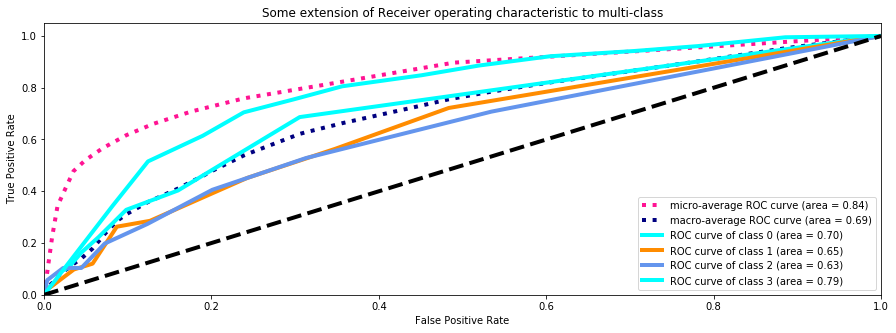

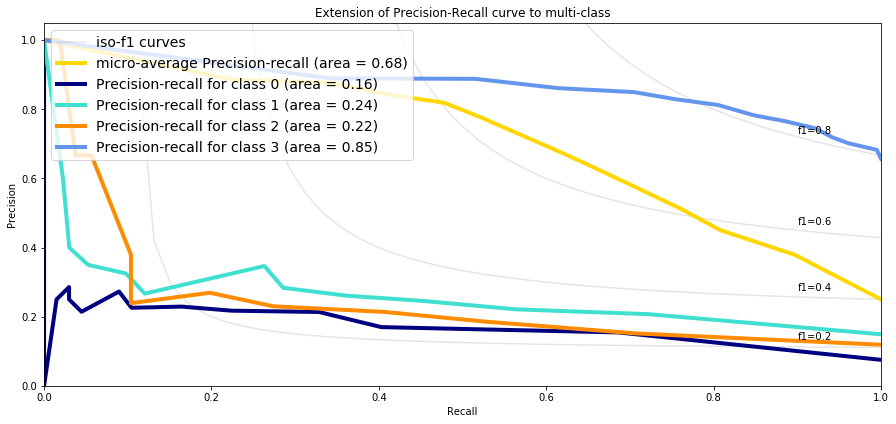

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.405995
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.6920455654026024
Code block 'training' took(HH:MM:SS): 0:00:00.186668
Code block 'testing' took(HH:MM:SS): 0:00:00.005423
F1 score 0.619412863754701
Classification report  
               precision    recall  f1-score   support

           1       0.34      0.27      0.30        67
           2       0.34      0.29      0.31       133
           3       0.22      0.13      0.16       106
           4       0.76      0.86      0.81       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.41      0.39      0.40       892
weighted avg       0.60      0.64      0.62       892



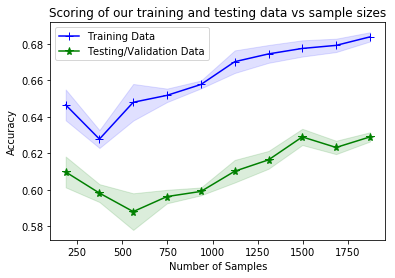

Confusion matrix, without normalization
[[ 18  15   9  25]
 [ 15  39  11  68]
 [  9  19  14  64]
 [ 11  42  30 503]]


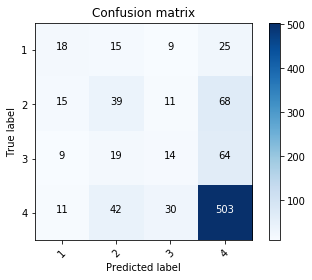

Code block 'learning_curve' took(HH:MM:SS): 0:00:11.132156
inside decision function


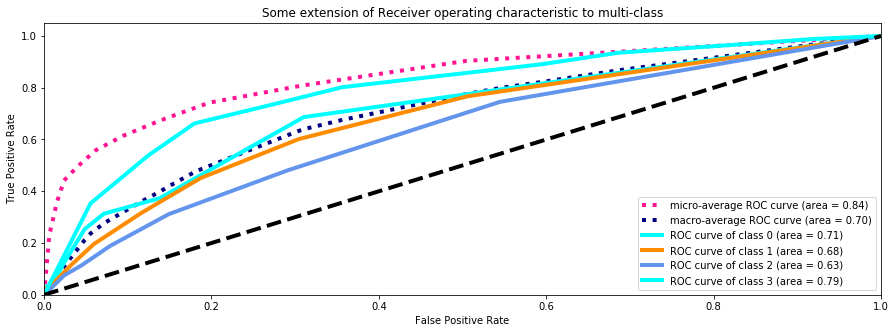

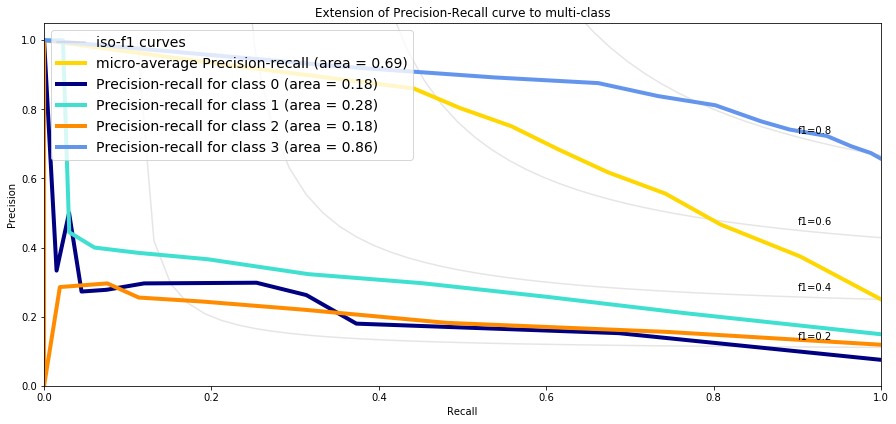

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.422000
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.6566353200383552
Code block 'training' took(HH:MM:SS): 0:00:00.188089
Code block 'testing' took(HH:MM:SS): 0:00:00.000249
F1 score 0.6055660898633115
Classification report  
               precision    recall  f1-score   support

           1       0.29      0.09      0.14        67
           2       0.36      0.27      0.31       133
           3       0.29      0.08      0.12       106
           4       0.73      0.92      0.81       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.41      0.34      0.34       892
weighted avg       0.59      0.66      0.61       892



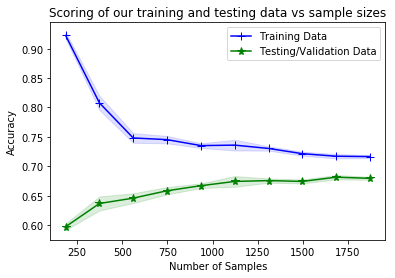

Confusion matrix, without normalization
[[  6  23   0  38]
 [  8  36   7  82]
 [  3  14   8  81]
 [  4  28  13 541]]


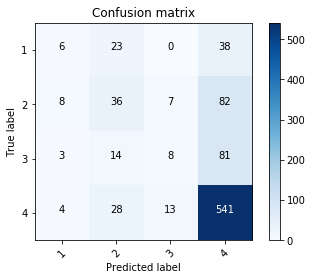

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.548532
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000020
Grid Search Best parameters  {'svc__C': 1.2, 'svc__max_iter': 200}
Grid Search Best score  0.11562999365231905
Code block 'training' took(HH:MM:SS): 0:00:05.075096
Code block 'testing' took(HH:MM:SS): 0:00:00.015949
F1 score 0.06884755175804892
Classification report  
               precision    recall  f1-score   support

           1       0.09      0.40      0.15        67
           2       0.18      0.27      0.21       133
           3       0.14      0.51      0.22       106
           4       0.00      0.00      0.00       586

   micro avg       0.13      0.13      0.13       892
   macro avg       0.10      0.30      0.14       892
weighted avg       0.05      0.13      0.07       892



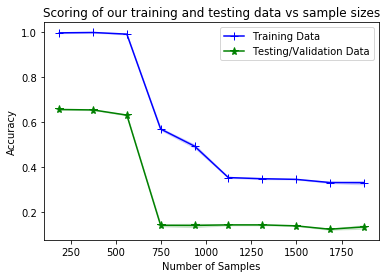

Confusion matrix, without normalization
[[ 27  14  26   0]
 [ 34  36  63   0]
 [ 28  24  54   0]
 [205 128 253   0]]


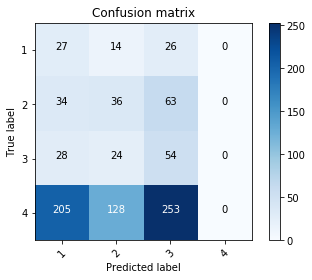

Code block 'learning_curve' took(HH:MM:SS): 0:03:04.509440
inside decision function


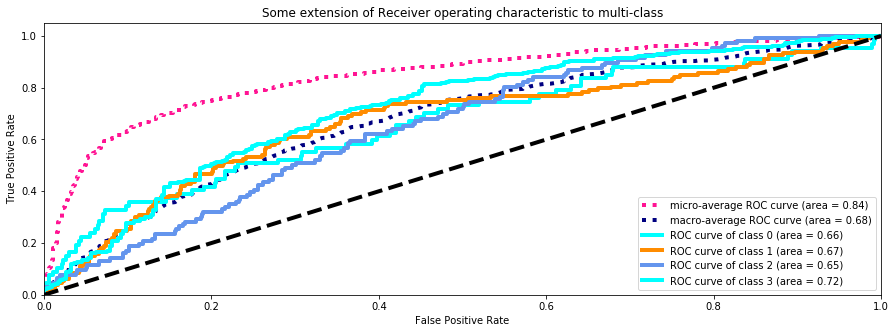

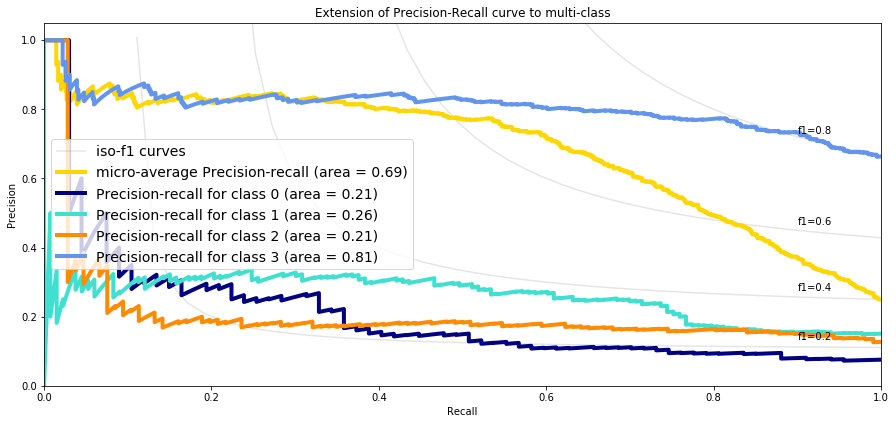

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.514726
Code block 'overalltime' took(HH:MM:SS): 0:03:47.154061
227154.06075617828


In [23]:
response = execute(x_train_lda,
        _y_train,
        x_test_lda,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [24]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
ridge,0.605566,0.344554,0.662556,1548.53,0,0,0.249173,188.089
logisticregression,0.606791,0.35699,0.650224,11696.6,0.73682,0.85688,0.86528,94.9555
randomforestclassifier,0.622599,0.380334,0.643498,4003.24,0.693378,0.835225,3.71371,366.398
kneighborsclassifier,0.619413,0.396651,0.643498,11132.2,0.704902,0.840619,5.42322,186.668
decisiontreeclassifier,0.584817,0.350409,0.59417,3704.97,0.598668,0.733352,0.222435,264.163
perceptron,0.585202,0.342726,0.571749,1928.51,0,0,0.147911,126.561
svc,0.0688476,0.144912,0.131166,184509,0.678605,0.843783,15.9488,5075.1


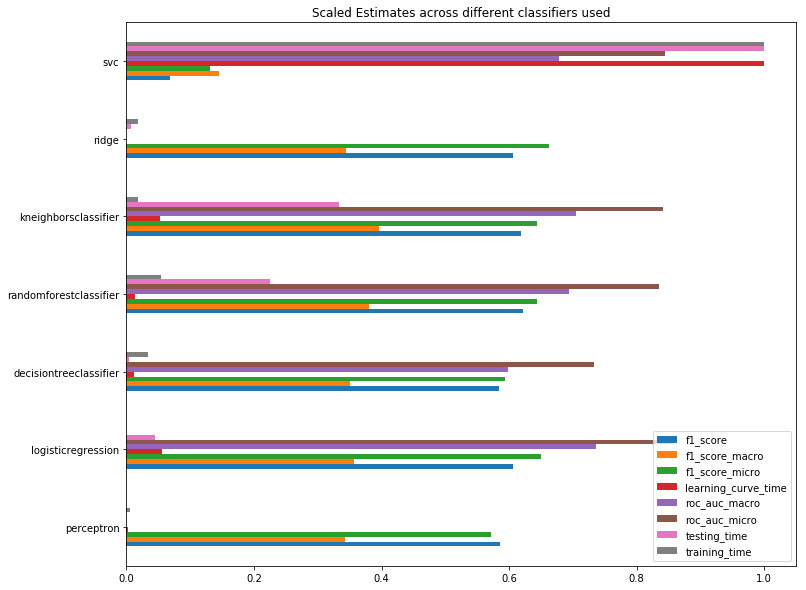

In [25]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion: We do see better f1 macro score for Kneighbor classifier using LDA reduction

Lets undersample the minorities now


In [26]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)




In [27]:
## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

# smt = SMOTETomek(ratio='auto')
# _x_train, _y_train = smt.fit_sample(_x_train, _y_train)

# smote = SMOTE(ratio='minority')
# x_train, y_train = smote.fit_sample(_x_train,_y_train)

tl = TomekLinks(return_indices=True, ratio='majority')
_x_train, _y_train, id_tl = tl.fit_sample(_x_train, _y_train)



In [28]:
scaler = StandardScaler()
x_train_std = scaler.fit_transform(_x_train)
x_test_std = scaler.fit_transform(_x_test)

In [29]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_std, _y_train)
x_train_lda = lda.transform(x_train_std)
x_test_lda = lda.transform(x_test_std)


In [30]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 5}
Grid Search Best score  0.6180514711837707
Code block 'training' took(HH:MM:SS): 0:00:00.146035
Code block 'testing' took(HH:MM:SS): 0:00:00.000497
F1 score 0.6015049932548419
Classification report  
               precision    recall  f1-score   support

           1       0.13      0.09      0.11        67
           2       0.27      0.24      0.25       133
           3       0.23      0.46      0.31       106
           4       0.85      0.74      0.79       586

   micro avg       0.58      0.58      0.58       892
   macro avg       0.37      0.38      0.36       892
weighted avg       0.63      0.58      0.60       892



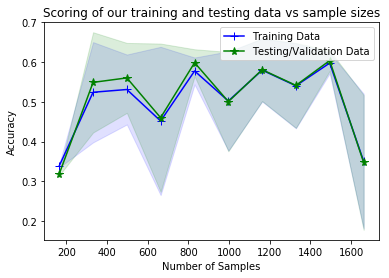

Confusion matrix, without normalization
[[  6  12  34  15]
 [ 12  32  55  34]
 [  8  20  49  29]
 [ 21  55  76 434]]


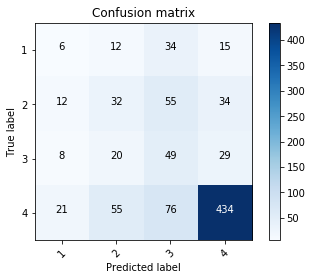

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.515593
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000020
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.6780105774004338
Code block 'training' took(HH:MM:SS): 0:00:00.097583
Code block 'testing' took(HH:MM:SS): 0:00:00.000317
F1 score 0.6173320679813795
Classification report  
               precision    recall  f1-score   support

           1       0.27      0.13      0.18        67
           2       0.32      0.31      0.31       133
           3       0.23      0.12      0.16       106
           4       0.77      0.88      0.82       586

   micro avg       0.65      0.65      0.65       892
   macro avg       0.40      0.36      0.37       892
weighted avg       0.60      0.65      0.62       892



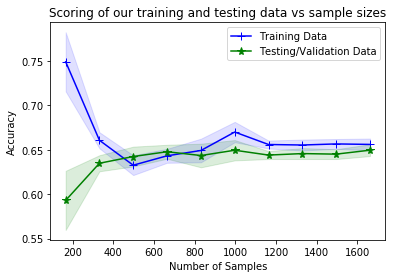

Confusion matrix, without normalization
[[  9  26   4  28]
 [ 12  41  13  67]
 [  4  26  13  63]
 [  8  36  26 516]]


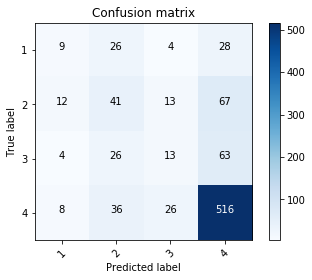

Code block 'learning_curve' took(HH:MM:SS): 0:00:10.185648
inside decision function


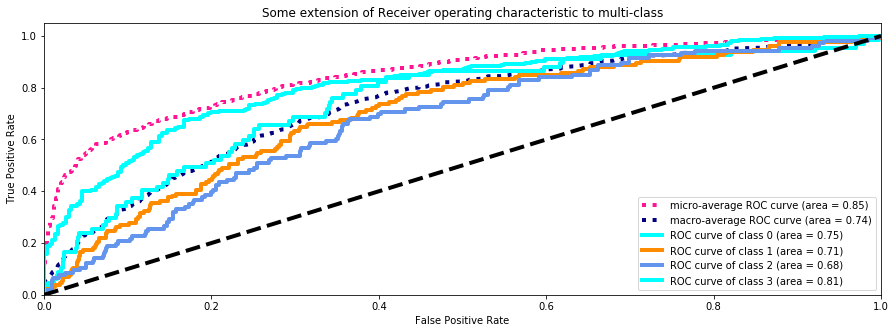

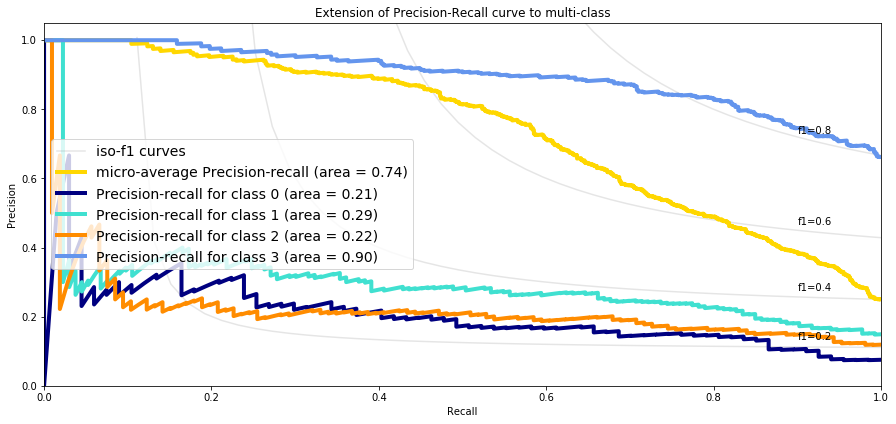

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.456471
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 6}
Grid Search Best score  0.658940964144769
Code block 'training' took(HH:MM:SS): 0:00:00.229720
Code block 'testing' took(HH:MM:SS): 0:00:00.000491
F1 score 0.6186831033735284
Classification report  
               precision    recall  f1-score   support

           1       0.24      0.19      0.21        67
           2       0.29      0.35      0.32       133
           3       0.24      0.17      0.20       106
           4       0.80      0.82      0.81       586

   micro avg       0.63      0.63      0.63       892
   macro avg       0.39      0.38      0.38       892
weighted avg       0.61      0.63      0.62       892



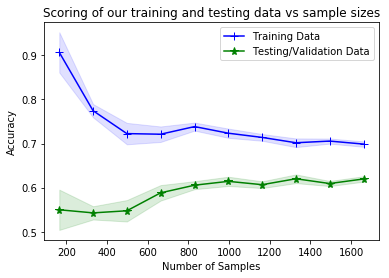

Confusion matrix, without normalization
[[ 13  25   9  20]
 [ 15  46  17  55]
 [ 10  30  18  48]
 [ 17  56  31 482]]


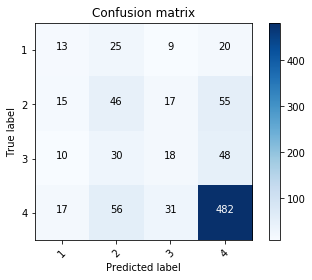

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.014293
inside decision function


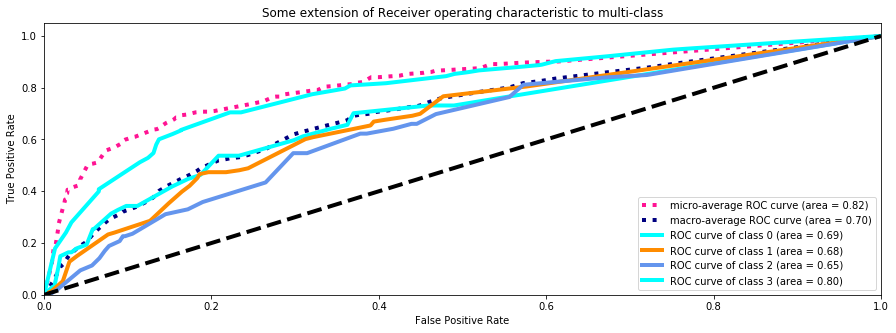

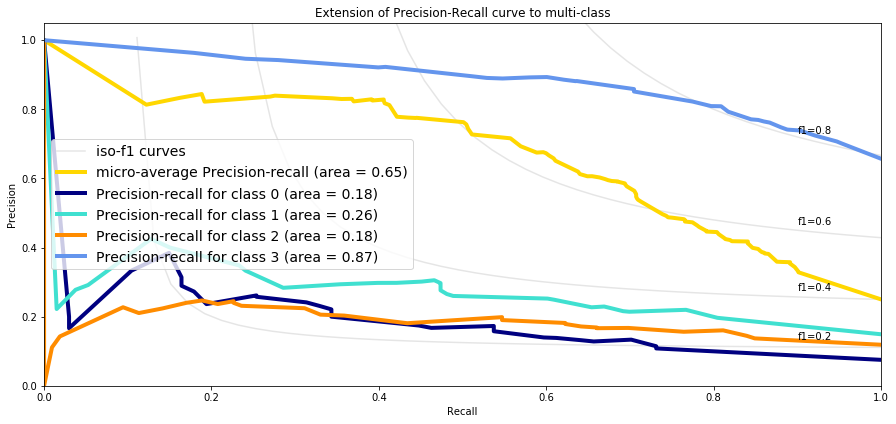

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.467800
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.6606613832397663
Code block 'training' took(HH:MM:SS): 0:00:00.358261
Code block 'testing' took(HH:MM:SS): 0:00:00.003412
F1 score 0.6271297252183545
Classification report  
               precision    recall  f1-score   support

           1       0.29      0.25      0.27        67
           2       0.31      0.35      0.33       133
           3       0.26      0.20      0.22       106
           4       0.80      0.82      0.81       586

   micro avg       0.63      0.63      0.63       892
   macro avg       0.41      0.40      0.41       892
weighted avg       0.62      0.63      0.63       892



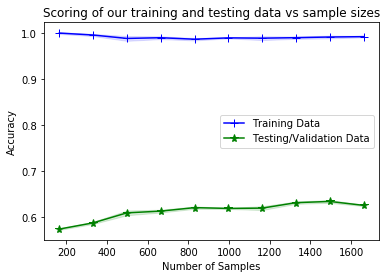

Confusion matrix, without normalization
[[ 17  20  11  19]
 [ 17  46  13  57]
 [  7  32  21  46]
 [ 18  51  36 481]]


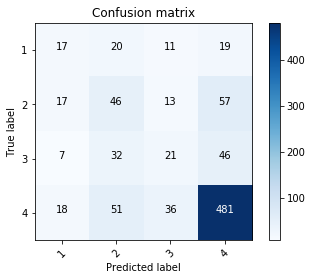

Code block 'learning_curve' took(HH:MM:SS): 0:00:03.280594
inside decision function


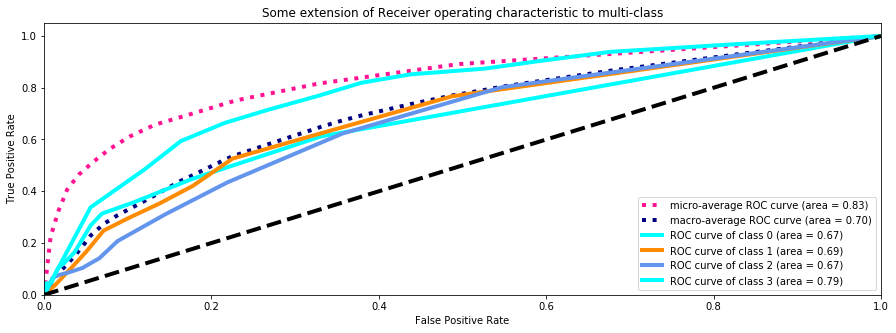

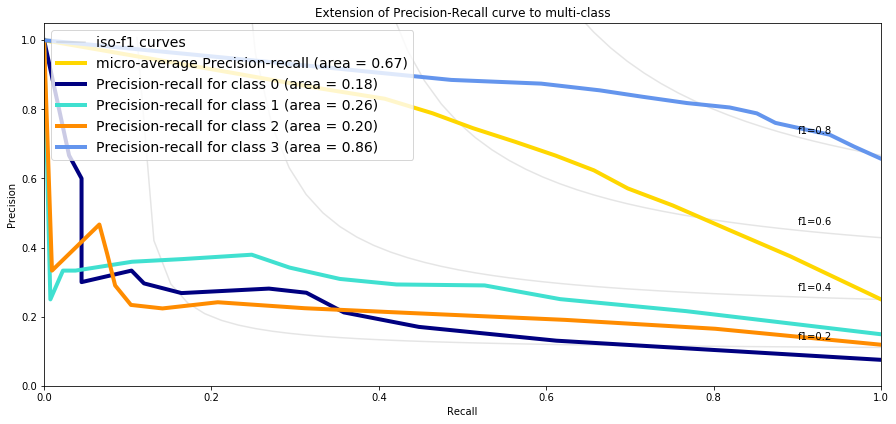

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.410973
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.6753675920737321
Code block 'training' took(HH:MM:SS): 0:00:00.169323
Code block 'testing' took(HH:MM:SS): 0:00:00.005346
F1 score 0.6198801625625623
Classification report  
               precision    recall  f1-score   support

           1       0.29      0.22      0.25        67
           2       0.31      0.33      0.32       133
           3       0.24      0.21      0.22       106
           4       0.79      0.82      0.80       586

   micro avg       0.63      0.63      0.63       892
   macro avg       0.41      0.39      0.40       892
weighted avg       0.61      0.63      0.62       892



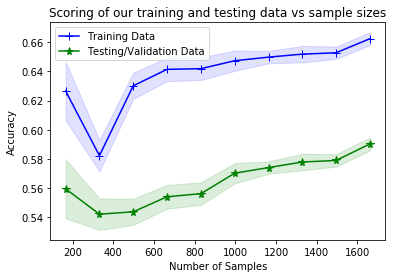

Confusion matrix, without normalization
[[ 15  18  11  23]
 [ 18  44  16  55]
 [  6  25  22  53]
 [ 12  54  41 479]]


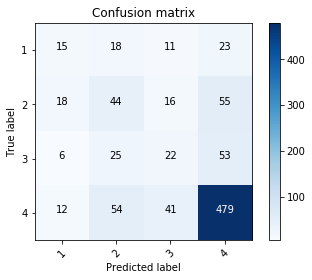

Code block 'learning_curve' took(HH:MM:SS): 0:00:08.584901
inside decision function


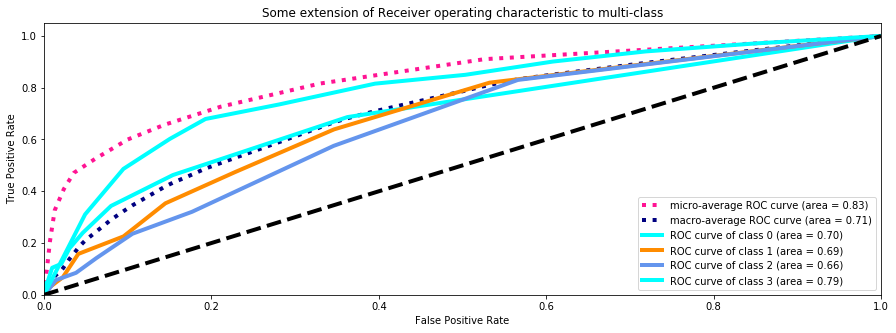

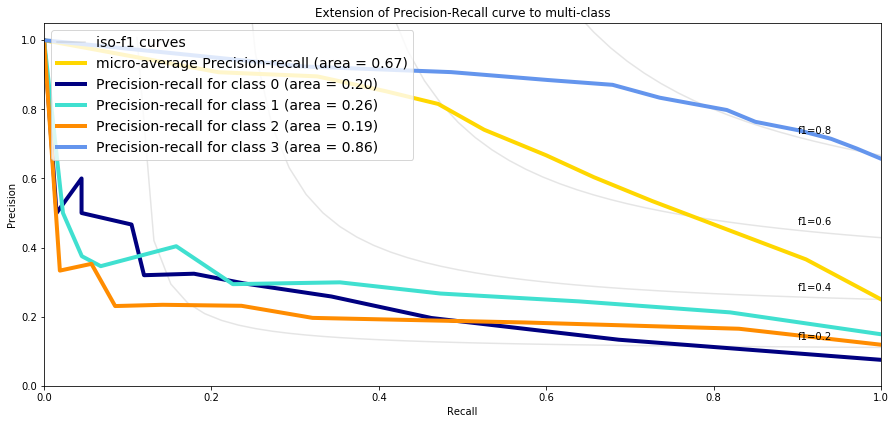

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.427517
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.658250392097382
Code block 'training' took(HH:MM:SS): 0:00:00.181696
Code block 'testing' took(HH:MM:SS): 0:00:00.000527
F1 score 0.6079009394648698
Classification report  
               precision    recall  f1-score   support

           1       0.28      0.10      0.15        67
           2       0.31      0.30      0.31       133
           3       0.21      0.08      0.11       106
           4       0.75      0.90      0.82       586

   micro avg       0.65      0.65      0.65       892
   macro avg       0.39      0.34      0.35       892
weighted avg       0.59      0.65      0.61       892



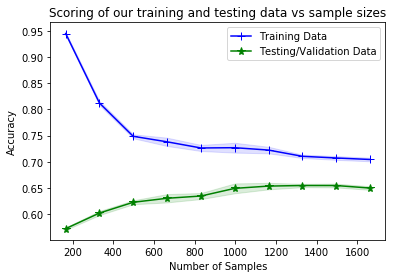

Confusion matrix, without normalization
[[  7  26   1  33]
 [  9  40  11  73]
 [  4  27   8  67]
 [  5  36  19 526]]


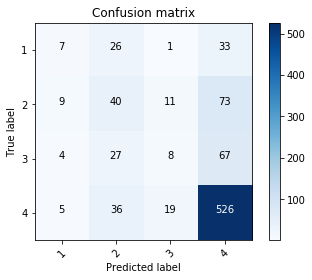

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.931453
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000013
Grid Search Best parameters  {'svc__C': 1.2, 'svc__max_iter': 200}
Grid Search Best score  0.13776706129387822
Code block 'training' took(HH:MM:SS): 0:00:04.568477
Code block 'testing' took(HH:MM:SS): 0:00:00.015622
F1 score 0.0819926154517651
Classification report  
               precision    recall  f1-score   support

           1       0.12      0.52      0.19        67
           2       0.29      0.31      0.30       133
           3       0.12      0.51      0.19       106
           4       0.00      0.00      0.00       586

   micro avg       0.15      0.15      0.15       892
   macro avg       0.13      0.34      0.17       892
weighted avg       0.07      0.15      0.08       892



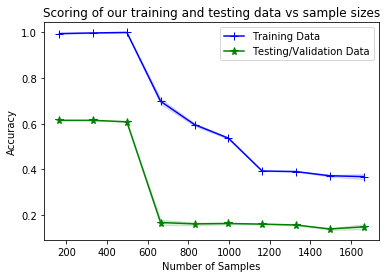

Confusion matrix, without normalization
[[ 35  15  17   0]
 [ 41  41  51   0]
 [ 25  27  54   0]
 [200  58 328   0]]


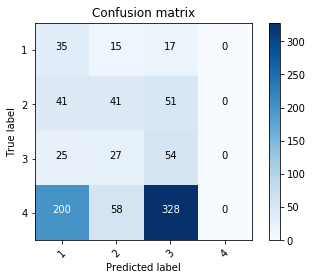

Code block 'learning_curve' took(HH:MM:SS): 0:02:40.759987
inside decision function


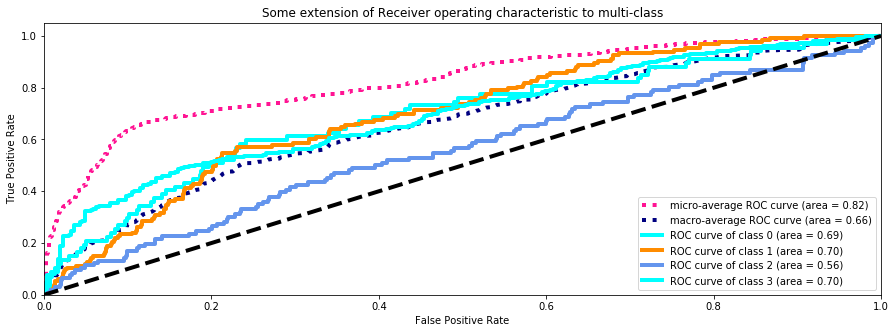

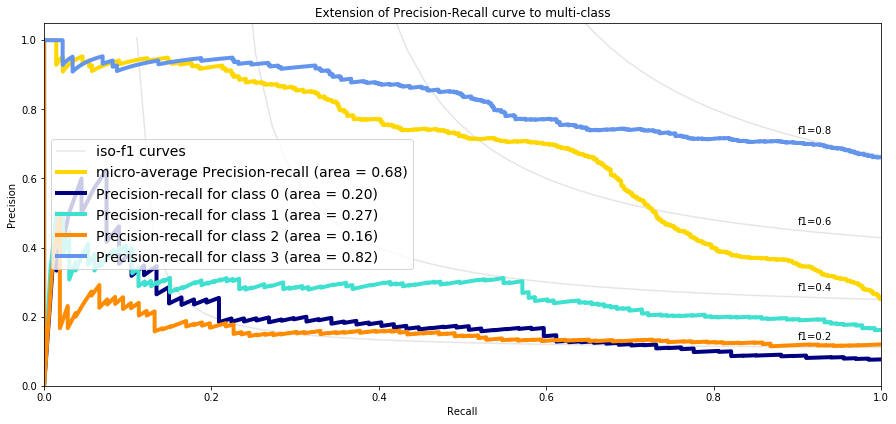

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.486642
Code block 'overalltime' took(HH:MM:SS): 0:03:15.358503
195358.50286691482


In [31]:
response = execute(x_train_lda,
        _y_train,
        x_test_lda,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [32]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
ridge,0.607901,0.346635,0.651345,931.453,0,0,0.52736,181.696
logisticregression,0.617332,0.36813,0.649103,10185.6,0.73601,0.850174,0.316871,97.5826
randomforestclassifier,0.62713,0.407441,0.633408,3280.59,0.704818,0.831074,3.41219,358.261
kneighborsclassifier,0.61988,0.400225,0.627803,8584.9,0.711064,0.833888,5.34642,169.323
decisiontreeclassifier,0.618683,0.384664,0.626682,2014.29,0.703114,0.818412,0.490951,229.72
perceptron,0.601505,0.364002,0.584081,1515.59,0,0,0.49664,146.035
svc,0.0819926,0.170933,0.14574,160760,0.662293,0.82261,15.6217,4568.48


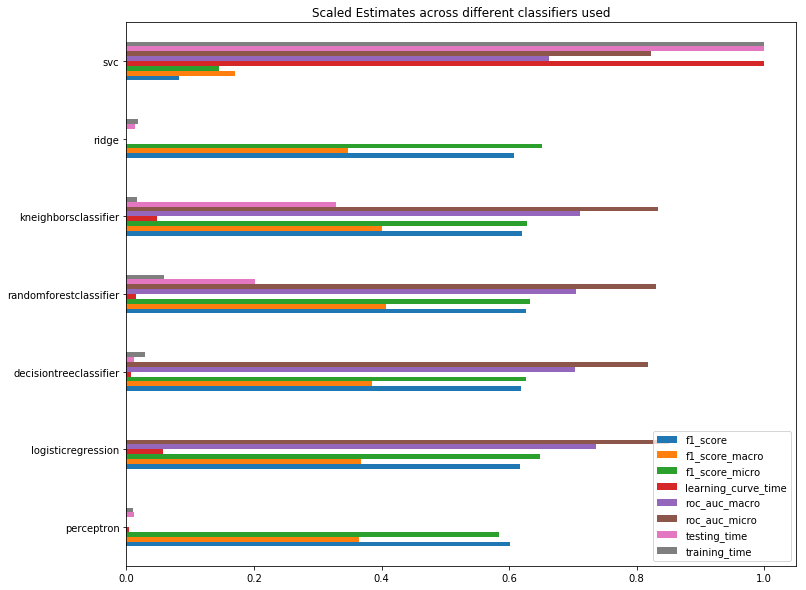

In [33]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion: We do see better f1 macro score for Kneighbor and RandomForest classifier . However our randomforestclassifier has greater tendency to overfit. Hence we would be using KNeighborClassifier using under sampling techniques